In [ ]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from operator import add
import copy
import random
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from IPython import embed
import time

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
#@title NN definition
class Net(nn.Module):
    def __init__(self,environment):
        super().__init__()

        self.fc1 = nn.Linear(environment.observation_space[0].shape[0]+environment.observation_space[1].shape[0], 128)
        self.fc2 = nn.Linear(128, environment.action_space[0].n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class doubleDQN():
    def __init__(self, agent_id):
        self.hyper_params = {}
        self.agent_id = agent_id
        self.original_network = Net(env)
        self.target_network = Net(env)
        self.target_network.load_state_dict(self.original_network.state_dict())
        self.number_episodes = 1000
        self.optimizer = optim.SGD(self.original_network.parameters(), lr=learning_rate)
        self.MSE_loss = torch.nn.MSELoss()

    def act(self, state):
        q_values = self.original_network(torch.Tensor(state)).data.numpy()
        max_q_act = np.argmax(q_values)
        return max_q_act

    def update_batch(self,batch):

        for state, action, reward, done, next_state in batch:
            action = action[self.agent_id]
            if all(done):
                target = reward
            else:

                t_qvals = self.original_network(torch.Tensor(next_state)).data.numpy()
                t_qvals_max_act = np.argmax(t_qvals)

                next_target = self.target_network(torch.Tensor(next_state)).data.numpy()
                next_q_target = next_target[t_qvals_max_act]

                target = (reward + hyper_params['gamma'] * next_q_target)

            t_actual = self.original_network(torch.Tensor(state)).data.numpy()
            t_actual[action] = target

            self.optimizer.zero_grad()
            act_qval = self.original_network(torch.Tensor(state))
            loss = self.MSE_loss(act_qval, torch.Tensor(t_actual))

            loss.backward()
            self.optimizer.step()

    def run_agent(self):
        env = GridEnvironment()
        state = env.reset()
#         env.render()
        metrics['eval_rewards'] = [0]
        done = False
        total_reward =0
        while not done:
            action = self.act(state)
            observation, reward, done, _ = env.step(action)
            state = observation
            total_reward+=reward
            print(total_reward, action)
            metrics['eval_rewards'].append(total_reward)

        self.graph()
        return total_reward

    def run_agent_render(self,env_type):
        env = GridEnvironment()
        state = env.reset()
        env.render()
        time.sleep(2)
        metrics['eval_rewards'] = [0]
        done = False
        total_reward =0
        while not done:
            action = self.act(state)
            observation, reward, done, _ = env.step(action,'deterministic')
            state = observation
            total_reward+=reward
            print(total_reward, action)
            metrics['eval_rewards'].append(total_reward)
            env.render()
            time.sleep(2)

    def graph(self):
        plt.figure(figsize=(10, 8))
        plt.plot(metrics['total_rewards'], linewidth=1, color = 'maroon')
        plt.title('Title: Total Rewards per episode', fontsize=20, pad=20)
        plt.xlabel('Episode', fontsize=10)
        plt.ylabel('epsilon', fontsize=10)
        plt.grid()
        plt.show()


In [ ]:
# individual rewards own replay buffer, combined rewards

def train(env,agents,number_episodes):
    metrics['orig_rew'], metrics['total_rewards'], metrics['epsilon_decay'] = [], [], []
    buff_length = hyper_params['replay_length']
    replay_buff = [[],[]]
    epsilon = hyper_params['epsilon']
    min_epsilon = hyper_params['min_epsilon'] = 0.001

    for i in range(number_episodes):
        curr_state = env.reset()
        curr_state = np.array(curr_state).flatten()

        if i%5 == 0:
            for agent in agents:
                agent.target_network = copy.deepcopy(agent.original_network)

        done_n = [False for _ in range(env.n_agents)]
        step_count = 0
        total_reward = 0
        ori_rew = 0
        while not all(done_n):
#             env.render()
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = []
                for agent in agents:
                    act = agent.act(curr_state)
                    action.append(act)

            obs, reward, done_n, _ = env.step(action)
            obs = np.array(obs).flatten()

            ori_rew += sum(reward)
            rew_0 = 0
            rew_1 = 0

            if reward[0] == 9.99:
                rew_0 = 10

            if reward[0] == -10.01:
                rew_0 = -10

            if reward[1] == 0.9:
                rew_1 = -10

            if reward[1] == -1.01:
                rew_1 = 10

            sum_rew = sum(reward)
            reward[0] += rew_0
            reward[0] += sum_rew
            reward[1] += rew_1
            reward[1] += sum_rew

            total_reward += sum(reward)
            for agent in agents:
                if len(replay_buff[agent.agent_id]) >= buff_length:
                    replay_buff[agent.agent_id].pop(0)


                replay_buff[agent.agent_id].append([curr_state,action,reward[agent.agent_id],done_n,obs])
            curr_state = obs

            if all(done_n):
                print('TRUE')
            step_count += 1
            if step_count % 10 == 0:
                for agent in agents:
                    if len(replay_buff[agent.agent_id]) >= hyper_params['batch_size']:
                        transitions = random.sample(replay_buff[agent.agent_id], hyper_params['batch_size'])
                        agent.update_batch(transitions)


        if i%5 == 0:
            avg_rr = 0
            if i>=10:
                avg_rr = sum(metrics['total_rewards'][-10:])/10
            print("===============",i,"================")
            print('Total reward: ',total_reward,"    ",'Avg running reward: ',avg_rr,"    ",'Epsilon: ',epsilon)
        metrics['orig_rew'].append(ori_rew)
        metrics['total_rewards'].append(total_reward)
        metrics['epsilon_decay'].append(epsilon)
        epsilon = max(min_epsilon, epsilon * 0.995)

    return metrics['total_rewards'], metrics['epsilon_decay']

In [ ]:
# Combined rewards for both agents

def train(env,agents,number_episodes):
    metrics['orig_rew'], metrics['total_rewards'], metrics['epsilon_decay'] = [], [], []
    buff_length = hyper_params['replay_length']
    replay_buff = [[],[]]
    epsilon = hyper_params['epsilon']
    min_epsilon = hyper_params['min_epsilon'] = 0.001

    for i in range(number_episodes):
        curr_state = env.reset()
        curr_state = np.array(curr_state).flatten()

        if i%5 == 0:
            for agent in agents:
                agent.target_network = copy.deepcopy(agent.original_network)

#             done = False
        done_n = [False for _ in range(env.n_agents)]
        step_count = 0
        total_reward = 0
        ori_rew = 0
        while not all(done_n):
#             env.render()
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = []
                for agent in agents:
                    act = agent.act(curr_state)
                    action.append(act)

            obs, reward, done_n, _ = env.step(action)
            obs = np.array(obs).flatten()

            ori_rew += sum(reward)

            total_reward += sum(reward)
            for agent in agents:
                if len(replay_buff[agent.agent_id]) >= buff_length:
                    replay_buff[agent.agent_id].pop(0)

                replay_buff[agent.agent_id].append([curr_state,action,reward[agent.agent_id],done_n,obs])
            curr_state = obs

            if all(done_n):
                print('TRUE')
            step_count += 1
            if step_count % 10 == 0:
                for agent in agents:
                    if len(replay_buff[agent.agent_id]) >= hyper_params['batch_size']:
                        transitions = random.sample(replay_buff[agent.agent_id], hyper_params['batch_size'])
                        agent.update_batch(transitions)

        if i%5 == 0:
            avg_rr = 0
            if i>=10:
                avg_rr = sum(metrics['total_rewards'][-10:])/10
            print("===============",i,"================")
            print('Total reward: ',total_reward,"    ",'Avg running reward: ',avg_rr,"    ",'Epsilon: ',epsilon)
        metrics['orig_rew'].append(ori_rew)
        metrics['total_rewards'].append(total_reward)
        metrics['epsilon_decay'].append(epsilon)
        epsilon = max(min_epsilon, epsilon * 0.995)

    return metrics['total_rewards'], metrics['epsilon_decay']

In [ ]:
hyper_params = {}
hyper_params['max_timesteps'] = 100
hyper_params['epsilon'] = 1
hyper_params['epsilon_decay'] = 1.005
hyper_params['min_epsilon'] = 0.001
hyper_params['batch_size'] = 32
hyper_params['gamma'] = 0.99
hyper_params['replay_length'] = 2000
learning_rate = 0.001
metrics = {}
env = gym.make('ma_gym:Checkers-v0')
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
agent0 = doubleDQN(0)
agent1 = doubleDQN(1)
agents = [agent0, agent1]

total_rewards, epsilon_deacy = train(env, agents, 800)

env.close()

TRUE
=============== 0 ================
Total reward:  56.16000000000005      Avg running reward:  0      Epsilon:  1
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 5 ================
Total reward:  56.16      Avg running reward:  0      Epsilon:  0.9752487531218751
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 10 ================
Total reward:  14.000000000000014      Avg running reward:  48.95      Epsilon:  0.9511101304657719
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 15 ================
Total reward:  95.61999999999996      Avg running reward:  51.94400000000002      Epsilon:  0.9275689688183278
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 20 ================
Total reward:  105.31999999999994      Avg running reward:  53.614      Epsilon:  0.9046104802746175
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 25 ================
Total reward:  114.99999999999986      Avg running reward:  52.152      Epsilon:  0.8822202429488013
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 30 ================
Total reward:  -90.46

TRUE
TRUE
TRUE
=============== 240 ================
Total reward:  108.74      Avg running reward:  88.57399999999991      Epsilon:  0.30028896908517405
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 245 ================
Total reward:  123.75999999999989      Avg running reward:  100.29999999999994      Epsilon:  0.29285644267656924
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 250 ================
Total reward:  47.96000000000001      Avg running reward:  104.57799999999993      Epsilon:  0.285607880564032
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 255 ================
Total reward:  110.83999999999997      Avg running reward:  99.75399999999995      Epsilon:  0.27853872940185365
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 260 ================
Total reward:  125.07999999999996      Avg running reward:  98.51999999999994      Epsilon:  0.27164454854530906
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 265 ================
Total reward:  50.99999999999984      Avg running reward:  103.86599999999994      Eps

TRUE
TRUE
TRUE
=============== 475 ================
Total reward:  162.13999999999996      Avg running reward:  140.84999999999997      Epsilon:  0.09246201511725258
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 480 ================
Total reward:  125.25999999999995      Avg running reward:  139.23399999999992      Epsilon:  0.09017346495423652
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 485 ================
Total reward:  125.61999999999996      Avg running reward:  129.17999999999992      Epsilon:  0.08794155926129824
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 490 ================
Total reward:  156.03999999999996      Avg running reward:  124.87199999999999      Epsilon:  0.08576489601717459
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 495 ================
Total reward:  111.97999999999998      Avg running reward:  125.33      Epsilon:  0.08364210790237678
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 500 ================
Total reward:  152.43999999999997      Avg running reward:  125.72399999999996  

TRUE
TRUE
TRUE
TRUE
TRUE
=============== 715 ================
Total reward:  124.47999999999992      Avg running reward:  125.10399999999993      Epsilon:  0.027765323199097504
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 720 ================
Total reward:  112.79999999999987      Avg running reward:  110.4159999999999      Epsilon:  0.02707809682994571
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 725 ================
Total reward:  88.79999999999998      Avg running reward:  106.89799999999994      Epsilon:  0.026407880170317945
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 730 ================
Total reward:  117.99999999999979      Avg running reward:  107.55199999999994      Epsilon:  0.025754252208694463
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 735 ================
Total reward:  118.49999999999997      Avg running reward:  124.57199999999993      Epsilon:  0.025116802354115567
TRUE
TRUE
TRUE
TRUE
TRUE
=============== 740 ================
Total reward:  149.04      Avg running reward:  139.6599

In [ ]:
#rewards
# 0.99
# 9.99
# -10.01
# -1.01
# -0.01

In [ ]:
import pickle

with open('rewards1.pkl','wb') as wfp:
    pickle.dump(total_rewards, wfp)

with open('rewards1.pkl','rb') as rfp:
    total_rewards_p = pickle.load(rfp)

In [ ]:
for agent in agents:
    torch.save(agent.original_network.state_dict(), './original_network1{}.pth'.format(agent.agent_id))
    torch.save(agent.target_network.state_dict(), './target_network1{}.pth'.format(agent.agent_id))


In [ ]:
len(total_rewards)

1000

In [ ]:
env.close()

In [ ]:
max(metrics['orig_rew'])

29.60000000000001

In [ ]:
print(env.spec.reward_threshold)

None


In [ ]:
#evaluate
enveval = gym.make('ma_gym:Checkers-v0')
def execute(num_episodes):
    steps_per_episode = []
    tot_rew_per_ep = []

    obs_n = enveval.reset()

    for episodes in range(num_episodes):

        done_n = [False for _ in range(enveval.n_agents)]
        ep_reward = 0

        obs_n = enveval.reset()
        step = 0
        obs_n = np.array(obs_n).flatten()

        while not all(done_n):
            enveval.render()
            time.sleep(1)

            action = []
            for agent in agents:
                act = agent.act(obs_n)
                action.append(act)
            print(action)
            obs_n, reward_n, done_n, info = enveval.step(action)
            obs_n = np.array(obs_n).flatten()
#             print(obs_n)
#             time.sleep(30)
            step+=1
            ep_reward += sum(reward_n)
            print(ep_reward,reward_n)


        steps_per_episode.append(step)
        tot_rew_per_ep.append(ep_reward)
    enveval.close()
    return steps_per_episode, tot_rew_per_ep


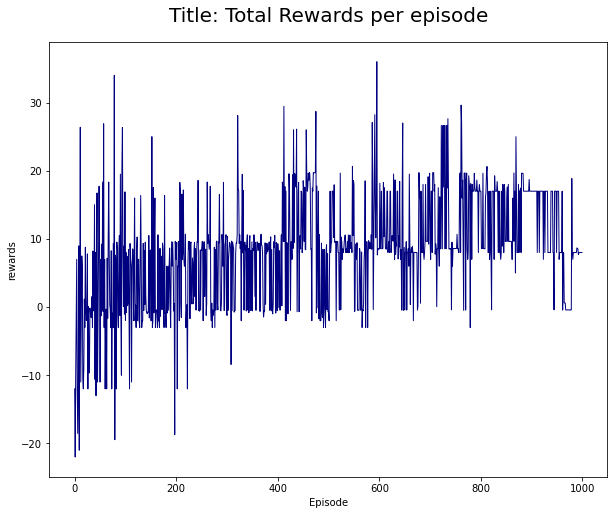

In [ ]:
# sending own rewards after modifying and enhancing reward fuction (adding combined rewards to both rewards), own replay buffer
#max rew: 37.00002
# -----------------------------------------


plt.figure(figsize=(10, 8))
# plt.plot(total_rewards, linewidth=1, color = 'maroon')
plt.plot(metrics['orig_rew'], linewidth=1, color = 'navy')

plt.title('Title: Total Rewards per episode', fontsize=20, pad=20)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('rewards', fontsize=10)
# plt.xlim(-10,750)
# plt.ylim(-40,75)
# plt.grid()
plt.show()

In [ ]:
steps_per_episode, tot_rew_per_ep = execute(10)

[0, 1]
-1.02 [-0.01, -1.01]
[1, 1]
9.96 [9.99, 0.99]
[4, 1]
8.940000000000001 [-0.01, -1.01]
[0, 1]
9.920000000000002 [-0.01, 0.99]
[1, 2]
8.900000000000002 [-0.01, -1.01]
[1, 1]
9.880000000000003 [-0.01, 0.99]
[2, 1]
18.860000000000003 [9.99, -1.01]
[1, 2]
19.840000000000003 [-0.01, 0.99]
[2, 3]
28.820000000000004 [9.99, -1.01]
[2, 0]
28.800000000000004 [-0.01, -0.01]
[1, 0]
27.780000000000005 [-0.01, -1.01]
[0, 1]
28.760000000000005 [-0.01, 0.99]
[2, 2]
28.740000000000006 [-0.01, -0.01]
[2, 2]
28.720000000000006 [-0.01, -0.01]
[2, 0]
28.700000000000006 [-0.01, -0.01]
[2, 2]
28.680000000000007 [-0.01, -0.01]
[2, 0]
28.660000000000007 [-0.01, -0.01]
[2, 2]
28.640000000000008 [-0.01, -0.01]
[2, 0]
28.620000000000008 [-0.01, -0.01]
[2, 2]
28.60000000000001 [-0.01, -0.01]
[2, 0]
28.58000000000001 [-0.01, -0.01]
[2, 2]
28.56000000000001 [-0.01, -0.01]
[2, 0]
28.54000000000001 [-0.01, -0.01]
[2, 2]
28.52000000000001 [-0.01, -0.01]
[2, 0]
28.50000000000001 [-0.01, -0.01]
[2, 2]
28.4800000000

KeyboardInterrupt: 

In [ ]:
enveval.close()

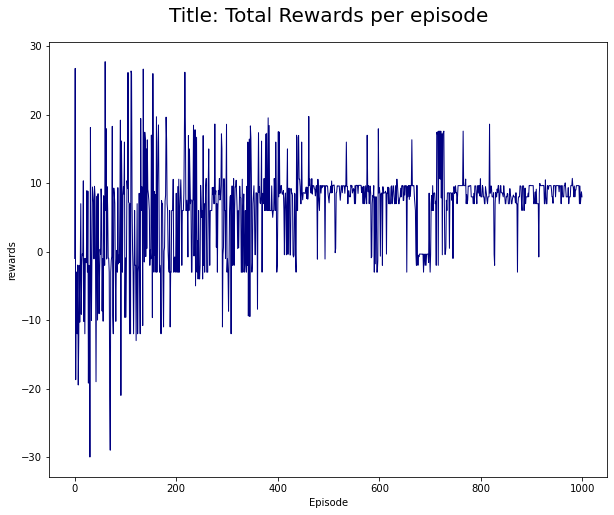

In [ ]:
# sending own rewards but not adding combined rewards, own replay buffer
#max rew: 27.34400001
# -----------------------------------------


plt.figure(figsize=(10, 8))
plt.plot(metrics['orig_rew'], linewidth=1, color = 'navy')

plt.title('Title: Total Rewards per episode', fontsize=20, pad=20)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('rewards', fontsize=10)

plt.show()

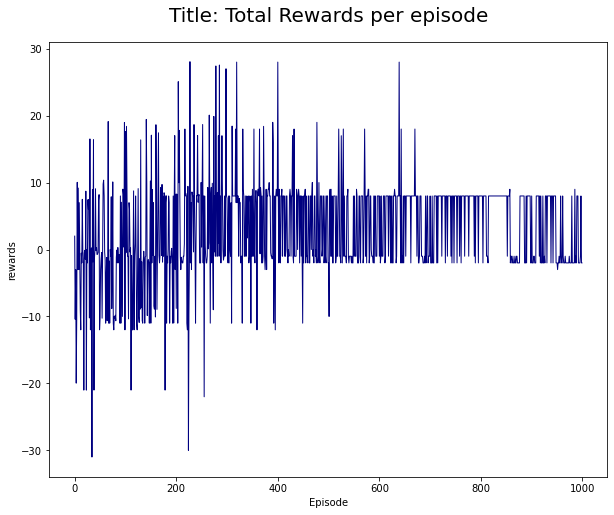

In [ ]:
#no change in reward own reolay buffer
# max rewards: 27.740000000000016

plt.figure(figsize=(10, 8))
plt.plot(metrics['orig_rew'], linewidth=1, color = 'navy')

plt.title('Title: Total Rewards per episode', fontsize=20, pad=20)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('rewards', fontsize=10)
plt.show()

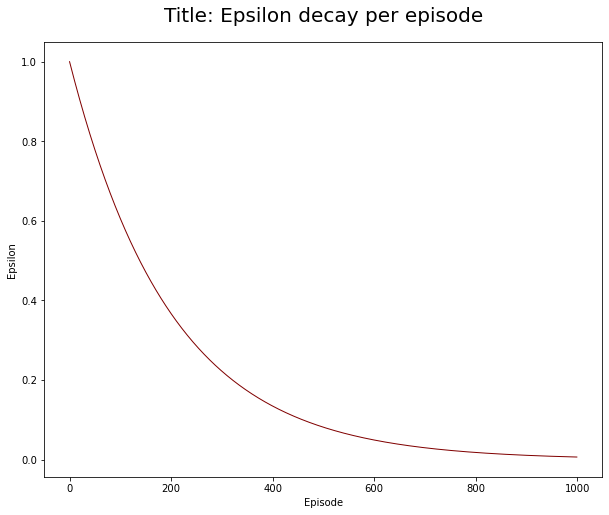

In [ ]:
#epsilon decay

plt.figure(figsize=(10, 8))
plt.plot(epsilon_deacy, linewidth=1, color = 'maroon')

plt.title('Title: Epsilon decay per episode', fontsize=20, pad=20)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('Epsilon', fontsize=10)
plt.show()

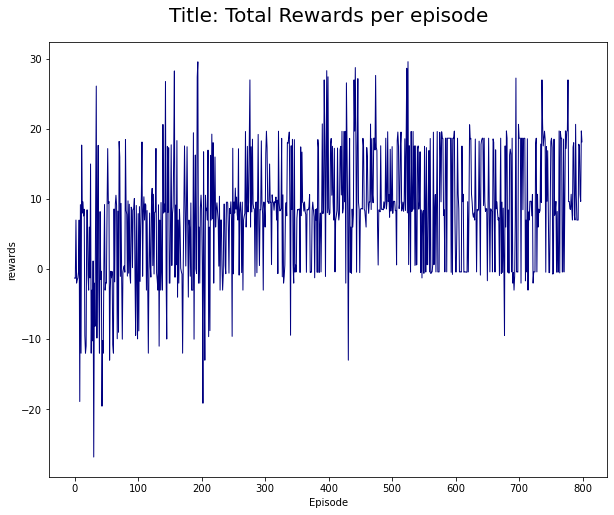

In [ ]:
# sending rewards obtained from environment without changing rewards, own reolay buffer
# max rewards: 28.00000567

plt.figure(figsize=(10, 8))
plt.plot(metrics['orig_rew'], linewidth=1, color = 'navy')

plt.title('Title: Total Rewards per episode', fontsize=20, pad=20)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('rewards', fontsize=10)
plt.show()

In [ ]:
import time
env = gym.make('ma_gym:Checkers-v0')
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
env.render()
total_rew = 0
for action in [[0,1],[1,1],[2,4],[1,0],[1,1],[0,0],[2,1],[1,1],[1,4],[1,1],[0,4],[3,0]]:
    time.sleep(1)
    obs_n, reward_n, done_n, info = env.step(action)
    print(reward_n)
    print(done_n)
    ep_reward = sum(reward_n)
    total_rew += ep_reward
    print(total_rew)
    env.render()
    time.sleep(2)

env.close()

[-0.01, -1.01]
[False, False]
-1.02
[9.99, 0.99]
[False, False]
9.96
[-10.01, -0.01]
[False, False]
-0.05999999999999872
[9.99, -0.01]
[False, False]
9.920000000000002
[-10.01, -1.01]
[False, False]
-1.0999999999999979
[9.99, -0.01]
[False, False]
8.880000000000003
[-0.01, 0.99]
[False, False]
9.860000000000003
[9.99, -1.01]
[False, False]
18.840000000000003
[-10.01, -0.01]
[False, False]
8.820000000000004
[9.99, 0.99]
[False, False]
19.800000000000004
[-10.01, -0.01]
[False, False]
9.780000000000005
[9.99, -0.01]
[True, True]
19.760000000000005


In [ ]:
env.close()